In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")

In [3]:
# Import all libraries
import pyfortracc
import numpy as np
import xarray as xr

In [4]:
pyfortracc.__version__

'1.1.5rc0'

In [5]:
def avg_intrp(X, d=1):
    """
    Interpolate NaN values in a 2D array using a moving window average.

    Args:
    X (numpy.ndarray): 2D input array with potential NaN values
    d (int): Size of the averaging window (default is 1)

    Returns:
    numpy.ndarray: Array with NaN values interpolated
    """
    # Create a copy of the input array to avoid modifying the original
    X = X.copy()

    # Find indices of NaN values
    bad_idx = np.argwhere(np.isnan(X))

    # Get dimensions of the array
    dim = X.shape

    # Create padded array
    row_pad = np.full((d, dim[1] + (2*d)), np.nan)
    col_pad = np.full((dim[0], d), np.nan)
    pad_X = np.pad(X, ((d, d), (d, d)), mode='constant', constant_values=np.nan)

    # Interpolate NaN values
    for idx in bad_idx:
        row, col = idx
        row_idx = slice(row, row + 2*d + 1)
        col_idx = slice(col, col + 2*d + 1)

        # Extract the window
        window = pad_X[row_idx, col_idx]

        # Calculate mean of non-NaN values
        valid_vals = window[~np.isnan(window)]
        if len(valid_vals) > 0:
            X[row, col] = np.mean(valid_vals)

    # Recursive interpolation if a small percentage of NaNs remain
    nan_ratio = np.sum(np.isnan(X)) / X.size
    if 0 < nan_ratio <= 0.05:
        X = avg_intrp(X, d)

    return X

In [7]:
def read_merg_ir(path):
    """
    Reads MERGIR data from a NetCDF file, extracting brightness temperature data.
    Args:
        path (str): Path to the MERGIR NetCDF file.
    Returns:
        numpy.ndarray: A 2D NumPy array containing the brightness temperature data
                         with dimensions (latitude, longitude). Returns the 'Tb' variable
                         inverted in the latitude dimension.
    """
    MERGIR_data = xr.open_dataset(path)
    brightness_temp = MERGIR_data['Tb'].values
    # Interpolate NaNs
    data_interpolated = avg_intrp(brightness_temp)
    return data_interpolated[::-1]

In [ ]:
# Get lat lon from first file
ds = xr.open_dataset("Half_hourly_files/202002250000.nc")

# Get the lon_min, lon_max, lat_min and lat_max of the domain
lon_min = float(ds['lon'].min().values)
lon_max = float(ds['lon'].max().values)
lat_min = float(ds['lat'].min().values)
lat_max = float(ds['lat'].max().values)

print(lon_max,lon_min,lat_min,lat_max)

179.9818115234375 -179.9818115234375 -59.981807708740234 59.981807708740234


In [ ]:
# Initialize an empty dictionary for the namelist
name_list = {}
name_list['input_path'] = 'Half_hourly_files/'
name_list['output_path'] = 'output/'

# Set features name list
name_list['thresholds'] = [235]
name_list['min_cluster_size'] = [150]
name_list['operator'] = '<='
name_list['timestamp_pattern'] = '%Y%m%d%H%M.nc'
name_list['delta_time'] = 30
name_list['cluster_method'] = 'ndimage'
name_list['edges'] = True

# Add correction methods
name_list['spl_correction'] = True # It is used to perform the correction at Splitting events
name_list['mrg_correction'] = True # It is used to perform the correction at Merging events

# Set min overlap percentage
name_list['min_overlap'] = 20

# Spatial parameters
name_list['lon_min'] = lon_min # Set the lon_min
name_list['lon_max'] = lon_max # Set the lon_max
name_list['lat_min'] = lat_min # Set the lat_min
name_list['lat_max'] = lat_max # Set the lat_max

In [10]:
pyfortracc.track(name_list, read_merg_ir)

Features Extraction:


100%|███████████████████████████████████| 6/6 +                     [Elapsed:00:33 Remaining:<00:00]


Spatial Operations:


100%|███████████████████████████████████| 6/6 +                     [Elapsed:00:01 Remaining:<00:00]


Cluster linking:


100%|███████████████████████████████████| 6/6 +                     [Elapsed:00:00 Remaining:<00:00]


Concatenating:


100%|███████████████████████████████████| 6/6 +                     [Elapsed:00:00 Remaining:<00:00]


In [11]:
# Import duckdb
import duckdb
con = duckdb.connect(database=':memory:', read_only=False)
tracking_table = con.execute(f"""SELECT * 
                             FROM parquet_scan('output/track/trackingtable/*.parquet',
                             union_by_name=True)
                             """).fetch_df()

In [12]:
# Set lat and lon to zoom
zz_lon_min = -56
zz_lon_max = -39
zz_lat_min = -50
zz_lat_max = -36
zoom_region = [zz_lon_min, zz_lon_max, zz_lat_min, zz_lat_max]

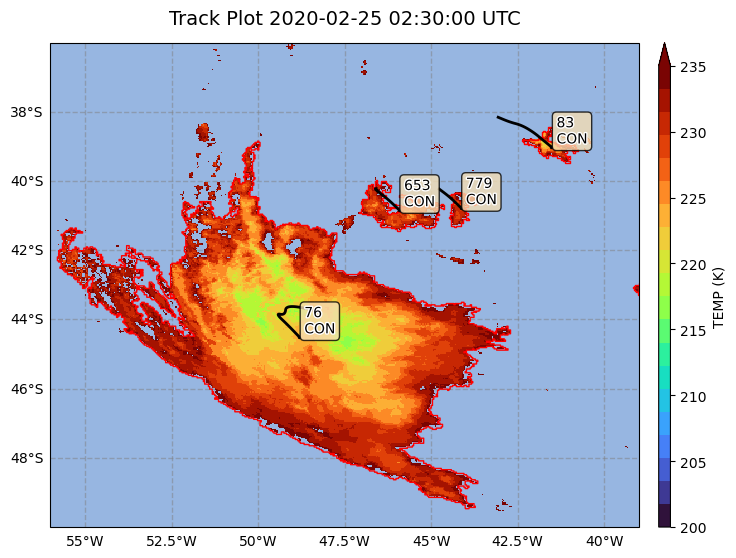

In [14]:
# Plot the tracking data for periods of time. 
pyfortracc.plot(read_function=read_merg_ir, # Read function
    figsize=(8,7), # Figure size
    name_list=name_list, # Name list dictionary
    timestamp ="2020-02-25 02:30:00", # Start timestamp
    info=True,
    info_col_name=False,
    info_cols=['uid','status'],
    cbar_title='TEMP (K)', # Colorbar title
    cmap='turbo', # Colormap
    min_val=200, # Min value
    max_val=235, # Max value
    nan_value=235, # NaN valu
    cbar_extend='max', # Colorbar extend
    nan_operation=np.greater_equal, # NaN operation
    box_fontsize=10, # Box fontsize
    zoom_region=zoom_region
    )


In [15]:
# Set lat and lon to zoom
zz_lon_min = -60
zz_lon_max = -35
zz_lat_min = -50
zz_lat_max = -36
zoom_region = [zz_lon_min, zz_lon_max, zz_lat_min, zz_lat_max]

In [16]:
# Visualize as animation.
pyfortracc.plot_animation(read_function=read_merg_ir, # Read function
                        figsize=(8,8), # Figure size
                        name_list=name_list, # Name list dictionary
                        start_timestamp = "2020-02-25 00:00:00", # Start timestamp
                        end_timestamp= "2020-02-25 03:00:00", # End timestamp
                        info_col_name=False, # Info column name
                        cbar_title='Temperature(k)', # Colorbar title
                        trajectory=True, # Plot the trajectory
                        smooth_trajectory=True, # Smooth the trajectory
                        cmap='turbo', # Colormap
                        min_val=200, # Min value
                        max_val=235, # Max value
                        nan_value=235, # NaN valu
                        cbar_extend='max', # Colorbar extend
                        nan_operation=np.greater_equal, # NaN operation
                        bound_color='blue', # Bound color
                        info_cols=['uid','status'], # Info columns from tracking table,
                        zoom_region=zoom_region,
                        parallel=True
                        )

Generating animation... 

In [17]:
# Set lat and lon to zoom
zz_lon_min = -160
zz_lon_max = -130
zz_lat_min = -60
zz_lat_max = -40
zoom_region = [zz_lon_min, zz_lon_max, zz_lat_min, zz_lat_max]
# Visualize as animation.
pyfortracc.plot_animation(read_function=read_merg_ir, # Read function
                        figsize=(8,8), # Figure size
                        name_list=name_list, # Name list dictionary
                        uid_list=[23, 633],
                        start_timestamp = "2020-02-25 00:00:00", # Start timestamp
                        end_timestamp= "2020-02-25 03:00:00", # End timestamp
                        info_col_name=False, # Info column name
                        cbar_title='Temperature(k)', # Colorbar title
                        trajectory=True, # Plot the trajectory
                        smooth_trajectory=True, # Smooth the trajectory
                        cmap='turbo', # Colormap
                        min_val=200, # Min value
                        max_val=235, # Max value
                        nan_value=235, # NaN value
                        cbar_extend='max', # Colorbar extend
                        nan_operation=np.greater_equal, # NaN operation
                        bound_color='blue', # Bound color
                        info_cols=['uid','status','size'], # Info columns from tracking table,
                        box_fontsize=7,
                        zoom_region=zoom_region,
                        parallel=True
                        )

Generating animation... 

In [20]:
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt


In [85]:
poligono_grande = Polygon([(-10, -10), (10, -10), (10, 10), (-10, 10), (-10, -10)])
poligono_pequeno = Polygon([(-5, -5), (5, -5), (5, 5), (-5, 5), (-5, -5)])
poligono_fora = Polygon([(15, 15), (20, 15), (20, 20), (15, 20), (15, 15)])
gdf_grande = gpd.GeoDataFrame({'geometry': [poligono_grande]})
gdf_pequeno = gpd.GeoDataFrame({'geometry': [poligono_pequeno]})
# gdf_fora = gpd.GeoDataFrame({'geometry': [poligono_fora]})

In [86]:
intersection = gpd.overlay(gdf_pequeno, gdf_grande,  how='intersection')

In [87]:
area1 = gdf_grande.area
area2 = gdf_pequeno.area

intersec_area = intersection.area
print(float(area1), float(area2), float(intersec_area))

400.0 100.0 100.0


In [88]:
at = (intersec_area / (area1 + area2 - intersec_area)) * 100
at2 = (intersec_area / area2) * 100
print(at, at2)

0    25.0
dtype: float64 0    100.0
dtype: float64


<Axes: >

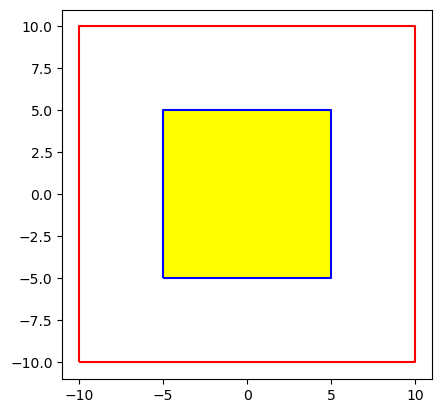

In [79]:
fig, ax = plt.subplots()
gdf_grande.boundary.plot(ax=ax, color='red')
gdf_pequeno.boundary.plot(ax=ax, color='blue')
# gdf_fora.boundary.plot(ax=ax, color='green')

intersection.plot(ax=ax, color='yellow')

In [60]:
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Criando dois polígonos que se sobrepõem
polygon1 = Polygon([(0, 0), (4, 0), (4, 4), (0, 4), (0, 0)])
polygon2 = Polygon([(2, 2), (6, 2), (6, 6), (2, 6), (2, 2)])

polygon1 = gpd.GeoDataFrame({'geometry': [polygon1]})
polygon2 = gpd.GeoDataFrame({'geometry': [polygon2]})

intersection = gpd.overlay(polygon1, polygon2, how='intersection')

In [70]:
area1 = polygon1.area
area2 = polygon2.area
area_inter = intersection.area

print('Área do polígono 1:', area1)
print('Área do polígono 2:', area2)
print('Área da interseção:', area_inter)

Área do polígono 1: 0    16.0
dtype: float64
Área do polígono 2: 0    16.0
dtype: float64
Área da interseção: 0    4.0
dtype: float64


In [71]:
at = (area_inter / (area1 + area2 - area_inter)) * 100
at2 = (area_inter / area2) * 100
print('Porcentagem de interseção:', float(at))
print('Porcentagem de interseção:', at2)

Porcentagem de interseção: 14.285714285714285
Porcentagem de interseção: 0    25.0
dtype: float64


<Axes: >

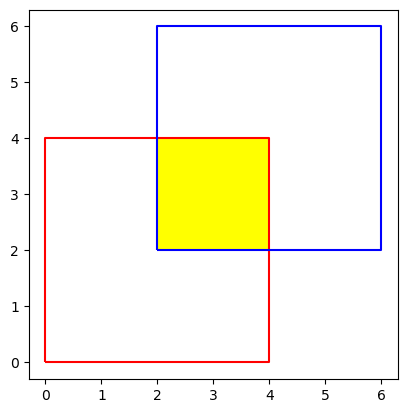

In [63]:
fig, ax = plt.subplots()
polygon1.boundary.plot(ax=ax, color='red')
polygon2.boundary.plot(ax=ax, color='blue')

intersection.plot(ax=ax, color='yellow')